<h1 align="center">Volume 3: Web Scraping 2</h1>
    <Name>
    <Class>
    <Date>

In [1]:
import re
import time
import requests
from bs4 import BeautifulSoup
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

from matplotlib import pyplot as plt, rcParams
%matplotlib inline
rcParams["figure.figsize"] = (16,12)    # Use this line to increase your figure size (optional).

## Problem 1
Modify `wunder_temp()` (below) so that it gathers the Actual Mean Temperature, Actual Max Temperature, and Actual Min Temperature for every day in July of 2012.
Plot these three measurements against time on the same plot.
Consider printing information at each iteration of the outer loop to keep track of the program’s progress.

Display the plot inline below.

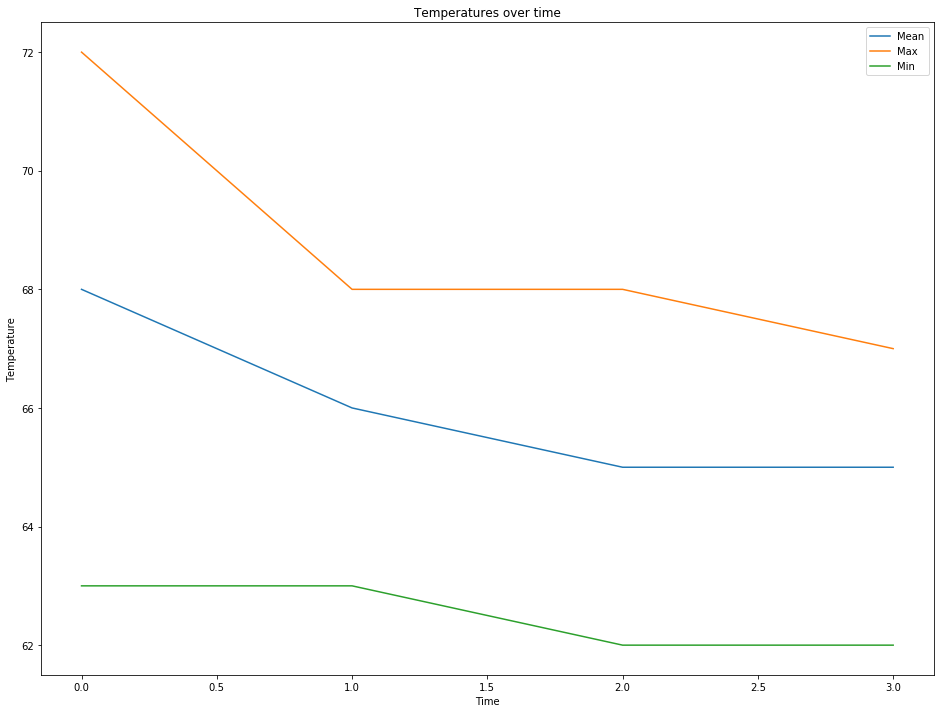

In [2]:
# Problem 1
def wunder_temp(day="/history/airport/KSAN/2012/7/1/DailyHistory.html"):
    """Crawl through Weather Underground and extract temperature data."""
    # Initialize variables, including a regex for finding the 'Next Day' link.
    actual_mean_temp = []
    actual_max_temp = []
    actual_min_temp = []
    next_day_finder = re.compile(r"Next Day")
    base_url = "https://www.wunderground.com"       # Web page base URL.
    page = base_url + day                           # Complete page URL.
    current = None
    temp_strings = [[actual_mean_temp,"Mean Temperature"], [actual_max_temp, "Max Temperature"], [actual_min_temp, "Min Temperature"]]

    for _ in range(4):
        for i in range(3):
            while current is None:  # Try downloading until it works.
                # Download the page source and PAUSE before continuing.
                page_source = requests.get(page).text
                time.sleep(1)           # PAUSE before continuing.
                soup = BeautifulSoup(page_source, "html.parser")
                current = soup.find(string=temp_strings[i][1])

            # Navigate to the relevant tag, then extract the temperature data.
            temp_tag = current.parent.parent.next_sibling.next_sibling.span.span
            temp_strings[i][0].append(int(temp_tag.string))
            current = None

        # Find the URL for the page with the next day's data.
        new_day = soup.find(string=next_day_finder).parent["href"]
        page = base_url + new_day                   # New complete page URL.
    
    return actual_mean_temp, actual_max_temp, actual_min_temp

temps = wunder_temp()
plt.plot(temps[0], label = 'Mean')
plt.plot(temps[1], label = 'Max')
plt.plot(temps[2], label = 'Min')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperatures over time')
plt.show()

## Problem 2

Modify `bank_data()` so that it extracts the total consolidated assets ("Consol Assets") for JPMorgan Chase, Bank of America, and Wells Fargo recorded each December from 2004 to the present.
In a single figure, plot each bank’s assets against time.
Be careful to keep the data sorted by date.

Display the plot inline below.

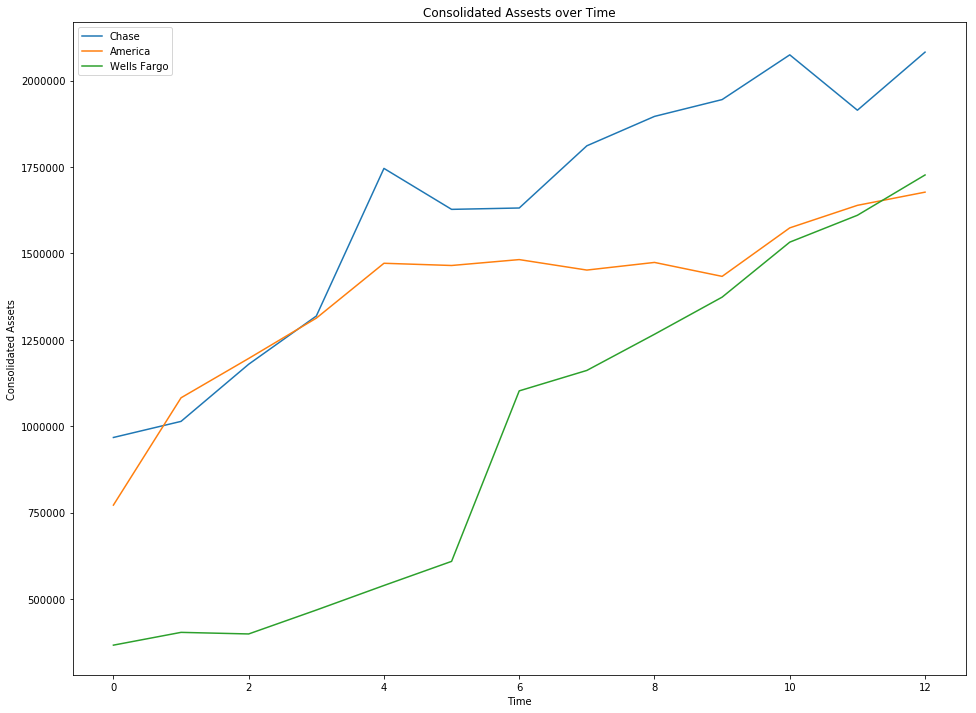

In [3]:
# Problem 2
def bank_data():
    """Crawl through the Federal Reserve site and extract bank data."""
    link_finder = re.compile(r"^December")
    chase_bank_finder = re.compile(r"^JPMORGAN CHASE BK")
    america_finder = re.compile(r"^BANK OF AMER NA")
    wells_fargo_finder = re.compile(r"^WELLS FARGO BK")

    base_url="https://www.federalreserve.gov/releases/lbr/"
    base_page_source = requests.get(base_url).text
    base_soup = BeautifulSoup(base_page_source, "html.parser")
    link_tags = base_soup.find_all(name='a', href=True, string=link_finder)
    pages = np.array([base_url + tag.attrs["href"] for tag in link_tags])
    pages = pages[:-1][::-1]
    
    chase_assets = []
    america_assets = []
    wells_fargo_assets = []
    for page in pages:
        time.sleep(1)
        soup = BeautifulSoup(requests.get(page).text, "html.parser")

        temp_tag = soup.find(name="td", string = chase_bank_finder)
        for _ in range(10):
            temp_tag = temp_tag.next_sibling
        chase_assets.append(int(temp_tag.string.replace(',', '')))
        
        temp_tag = soup.find(name="td", string = america_finder)
        for _ in range(10):
            temp_tag = temp_tag.next_sibling
        america_assets.append(int(temp_tag.string.replace(',', '')))
        
        temp_tag = soup.find(name="td", string = wells_fargo_finder)
        for _ in range(10):
            temp_tag = temp_tag.next_sibling
        wells_fargo_assets.append(int(temp_tag.string.replace(',', '')))

    return chase_assets, america_assets, wells_fargo_assets

temps = bank_data()
plt.plot(temps[0], label = 'Chase')
plt.plot(temps[1], label = 'America')
plt.plot(temps[2], label = 'Wells Fargo')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Consolidated Assets')
plt.title('Consolidated Assests over Time')
plt.show()

## Problem 3

ESPN hosts data on NBA athletes at http://www.espn.go.com/nba/statistics.
Each player has their own page with detailed performance statistics.
For each of the five offensive leaders in points and each of the five defensive leaders in rebounds, extract the player's career minutes per game (MPG) and career points per game (PPG).
Make a scatter plot of MPG against PPG for these ten players.

Display the plot inline below.

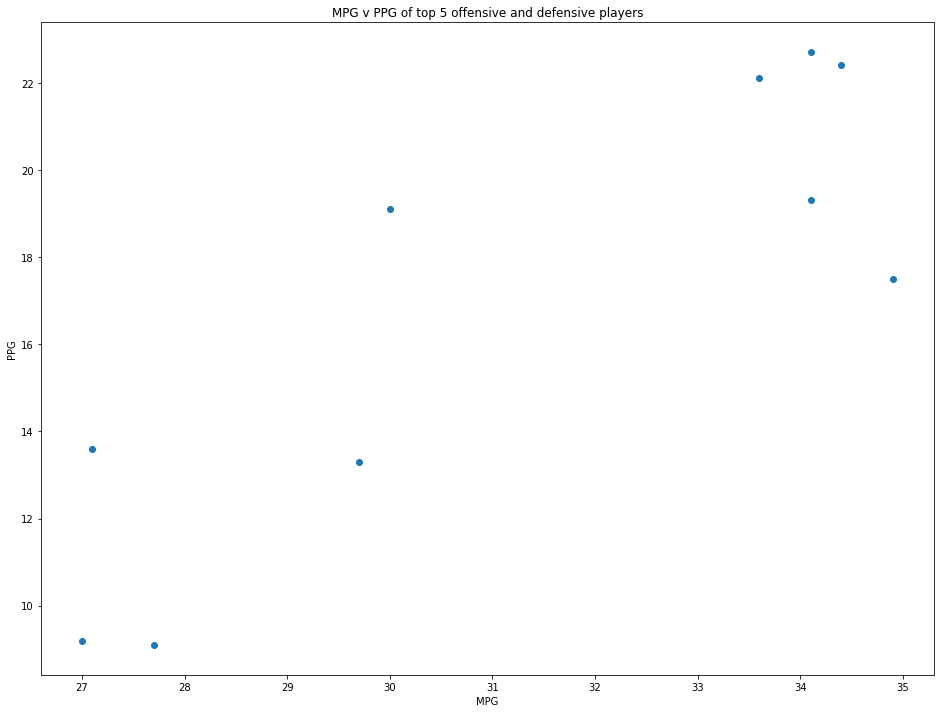

In [4]:
def nba_data():
    base_url="http://www.espn.com/nba/statistics"
    base_page_source = requests.get(base_url).text
    base_soup = BeautifulSoup(base_page_source, "html.parser")
    td_tags = base_soup.find_all(name='td')
    actual_tags = []
    for tag in td_tags:
        if '1. ' in tag.text or '2. ' in tag.text or '3. ' in tag.text or '4. ' in tag.text or '5. ' in tag.text:
            actual_tags.append(tag.a.attrs['href'])
    actual_tags = np.array(actual_tags)
    act_tags_offensive = actual_tags[:5]
    act_tags_defensive = actual_tags[15:20]
    MPG = []
    PPG = []
    for page in act_tags_offensive:
        time.sleep(1)
        soup = BeautifulSoup(requests.get(page).text, "html.parser")
        temp_tag = soup.find_all(name="td", text = "Career")[1]
        for i in range(15):
            temp_tag = temp_tag.next_sibling
            if i == 1:
                MPG.append(float(temp_tag.text))
        PPG.append(float(temp_tag.text))
    for page in act_tags_defensive:
        time.sleep(1)
        soup = BeautifulSoup(requests.get(page).text, "html.parser")
        temp_tag = soup.find_all(name="td", text = "Career")[1]
        for i in range(15):
            temp_tag = temp_tag.next_sibling
            if i == 1:
                MPG.append(float(temp_tag.text))
        PPG.append(float(temp_tag.text))
    plt.scatter(MPG, PPG)
    plt.ylabel('PPG')
    plt.xlabel('MPG')
    plt.title('MPG v PPG of top 5 offensive and defensive players')
    plt.show()
nba_data()

## Problem 4

The arXiv (pronounced "archive") is an online repository of scientific publications, hosted by Cornell University.
Write a function that accepts a string to serve as a search query.
Use Selenium to enter the query into the search bar of https://arxiv.org and press Enter.
The resulting page has up to 25 links to the PDFs of technical papers that match the query.
Gather these URLs, then continue to the next page (if there are more results) and continue gathering links until obtaining at most 100 URLs.

Print the list of URLs below.

In [5]:
def arxiv(s_query):
    browser = webdriver.Chrome()
    links = []
    try:
        base = "https://arxiv.org"
        browser.get(base)
        try:
            search_bar = browser.find_element_by_name('query')
            search_bar.clear()
            search_bar.send_keys(s_query)
            search_bar.send_keys(Keys.RETURN)
            soup = BeautifulSoup(browser.page_source, "html.parser")
            [links.append(base + val.a.next_sibling.next_sibling['href']) for val in soup.find_all(name="dt")]
            if soup.find(name = "a", text = re.compile(r"^Next [\d]* results$")):
                browser.get(base + soup.find(name = "a", text = re.compile(r"^Next [\d]* results$"))['href'])
                soup = BeautifulSoup(browser.page_source, "html.parser")
                [links.append(base + val.a.next_sibling.next_sibling['href']) for val in soup.find_all(name="dt")]
            if soup.find(name = "a", text = re.compile(r"^Next [\d]* results$")): 
                browser.get(base + soup.find(name = "a", text = re.compile(r"^Next [\d]* results$"))['href'])
                soup = BeautifulSoup(browser.page_source, "html.parser")
                [links.append(base + val.a.next_sibling.next_sibling['href']) for val in soup.find_all(name="dt")]
            if soup.find(name = "a", text = re.compile(r"^Next [\d]* results$")):
                browser.get(base + soup.find(name = "a", text = re.compile(r"^Next [\d]* results$"))['href'])
                soup = BeautifulSoup(browser.page_source, "html.parser")
                [links.append(base + val.a.next_sibling.next_sibling['href']) for val in soup.find_all(name="dt")]
        except NoSuchElementException:
            print("Could not find the search bar!")
            raise
    finally:
        browser.close()
    return links
arxiv("summer")

['https://arxiv.org/pdf/cond-mat/0703766',
 'https://arxiv.org/pdf/astro-ph/0703707',
 'https://arxiv.org/pdf/astro-ph/0703496',
 'https://arxiv.org/pdf/hep-ph/0703297',
 'https://arxiv.org/pdf/gr-qc/0703079',
 'https://arxiv.org/pdf/cond-mat/0703058',
 'https://arxiv.org/pdf/hep-ex/0703010',
 'https://arxiv.org/pdf/cond-mat/0702526',
 'https://arxiv.org/pdf/cond-mat/0702399',
 'https://arxiv.org/pdf/astro-ph/0702235',
 'https://arxiv.org/pdf/astro-ph/0702198',
 'https://arxiv.org/pdf/cond-mat/0702122',
 'https://arxiv.org/pdf/cond-mat/0701375',
 'https://arxiv.org/pdf/cond-mat/0701350',
 'https://arxiv.org/pdf/hep-ph/0701273',
 'https://arxiv.org/pdf/cond-mat/0701193',
 'https://arxiv.org/pdf/cond-mat/0701181',
 'https://arxiv.org/pdf/gr-qc/0701124',
 'https://arxiv.org/pdf/hep-ex/0701054',
 'https://arxiv.org/pdf/hep-ex/0701040',
 'https://arxiv.org/pdf/astro-ph/0701017',
 'https://arxiv.org/pdf/cond-mat/0612418',
 'https://arxiv.org/pdf/astro-ph/0612370',
 'https://arxiv.org/pdf/hep

## Problem 5

Project Euler (https://projecteuler.net) is a collection of mathematical computing problems.
Each problem is listed with an ID, a description/title, and the number of users that have solved the problem.

Using Selenium, BeautifulSoup, or both, for each of the (at least) 600 problems in the archive at https://projecteuler.net/archives, record the problem ID and the number of people who have solved it.
Return a list of IDs, sorted from largest to smallest by the number of people who have solved them.
That is, the first entry in the list should be the ID of the most solved problem, and the last entry in the list should be the ID of the least solved problem.

Print the list of problems IDs below.

In [6]:
def euler():
    browser = webdriver.Chrome()
    IDs = []
    base = "https://projecteuler.net/archives"
    browser.get(base)
    soup = BeautifulSoup(browser.page_source, "html.parser")
    IDS = [int(val.td.text) for val in soup.find_all(name = "tr")[1:]]
    solved = [int(val.div.text) for val in soup.find_all(name = "tr")[1:]]
    ind = [solved.index(val) for val in np.sort(solved)[::-1]]
    IDS = [IDS[val] for val in ind]
    browser.close()
    return IDS

In [7]:
euler()

[1,
 2,
 3,
 6,
 5,
 4,
 7,
 9,
 8,
 10,
 11,
 16,
 13,
 14,
 12,
 20,
 15,
 25,
 17,
 18,
 21,
 19,
 22,
 48,
 24,
 28,
 30,
 29,
 23,
 34,
 36,
 27,
 35,
 31,
 26,
 40,
 42,
 37,
 39,
 33,
 45,
 32,
 41,
 38,
 50,
 46,
 43,
 47,
 49,
 44]